In [171]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
# Import statements required for Plotly 
import plotly.offline as py
py.init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings('ignore')

In [172]:
import os
data_folder = '/home/shuvayan/Downloads/Deloitte/'
attrition = pd.read_csv(data_folder + 'Attrition.csv')
attrition.head()

,Terminated,Rehire,Employee_code,Department,Job Level,Tenure,TimeLastPos,Has been promoted,LastRating,Client work travel,Education,Gender,Marital Status,Annual Income,Year of Birth,Age
0,0,False,117338,Audit,Staff I,15475,15294,Yes,2.000000,Medium Travel,Bachelors Degree,M,Single,135,1962,55
1,0,False,25687,Audit,Staff II,14719,14328,Yes,3.000000,Medium Travel,MBA,M,Married,1198,1977,40
2,0,False,10695,Finance,Staff I,14208,14040,Yes,1.965571,High Travel,Bachelor's Degree,F,Divorced,825,1986,31
3,0,True,88959,Audit,Staff I,6108,13825,Yes,2.000000,High Travel,MSc,F,Divorced,298,1964,53
4,0,False,72316,Sales,Staff I,13431,13408,Yes,2.000000,Low,Bachelors Degree,F,Single,111,1988,29


In [173]:
#Drop the employee code:
attrition.drop('Employee_code', axis=1, inplace=True)
#Calculate age from DOB column : Assumption - Employees have left in 2017
attrition.drop('Year of Birth',axis = 1,inplace = True)
attrition.isnull().any()

Terminated            False
Rehire                False
Department             True
Job Level             False
Tenure                False
TimeLastPos           False
Has been promoted     False
LastRating            False
Client work travel    False
Education             False
Gender                False
Marital Status        False
Annual Income         False
Age                   False
dtype: bool

In [174]:
#Only department has missing values,assign a seperate category to these records
attrition_df = attrition.fillna("unknown")
attrition_df.isnull().any()
attrition_df.columns.to_series().groupby(attrition_df.dtypes).groups
# The target column is in integer format,change to categorical
attrition_df['Terminated'] = attrition_df['Terminated'].astype('category')
# Summary statistics of the data:
attrition_df.describe()

,Tenure,TimeLastPos,LastRating,Annual Income,Age
count,11790.000000,11790.000000,11790.000000,11790.000000,11790.000000
mean,2156.817472,1163.517218,1.965571,2251.505852,40.006701
std,2333.153022,1550.358690,0.583920,1939.143494,8.915587
min,-1507.000000,0.000000,1.000000,100.000000,25.000000
25%,607.000000,244.000000,1.965571,790.250000,32.000000
50%,1279.000000,591.000000,2.000000,1718.500000,40.000000
75%,2948.000000,1433.750000,2.000000,2793.000000,48.000000
max,15475.000000,15294.000000,4.000000,9952.000000,55.000000


In [175]:
#There seem to be some spurious data which have tenure as -ve ,check if such records are less than 5% of the sample,if so delete.
attrition_df.Tenure.le(0).value_counts(True)
#This is a very small % hence remove these records
attrition_df.drop(attrition_df[attrition_df.Tenure < 0].index, inplace=True)

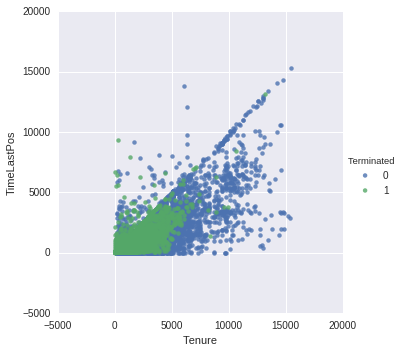

In [176]:
#Let's see the distribution of Terminated vis a vis Tenure and TimeLastPos
sns.lmplot('Tenure', 'TimeLastPos', data=attrition_df, hue='Terminated', fit_reg=False)
plt.show()

There is a huge concentration of Terminated = 1 around the region where both Tenure and TimeLastPos are low.It also seems that there are records where Tenure < TimeLastPos.Also there are records where TimeLastPos = 0 & also Hasbeenpromoted = 'Yes',which is clearly erroneous.So let us inspect these records.

In [177]:
attrition_err = attrition_df.loc[(attrition_df['TimeLastPos'] > attrition_df['Tenure']) | (attrition_df['TimeLastPos'] == 0)]
attrition_err.head()
attrition_err.shape

(1278, 14)

There are 1278 records which contain Tenure values which are less than TimeLastPos and where TimeLastPos = 0.For the records where TimeLastPos = 0 it can be assumed that they have been promoted recently and it is not updated in the system.But what about the records where Tenure < TimeLastPos.It is clearly an error and in absence of interaction with the database maintainer/business,inclination is to either remove such records or remove the variable TimeLastPos.But let's see the distribution of Terminated in these set of records.

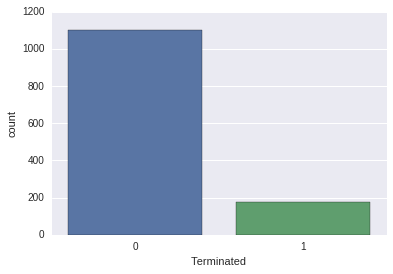

In [178]:
# Employees Left-Stayed Ratio
employees_left_plt = sns.countplot(x = "Terminated",data = attrition_err)

The proportion of Terminated = 0 is certainly much more than in the sample which includes this data also.Can it be that there is a reason for these anomalies to exist.Do they point towards something- might be an error during the data capturing process for these employees.
Now let us find out if the variable TimeLastPos is an important predictor.

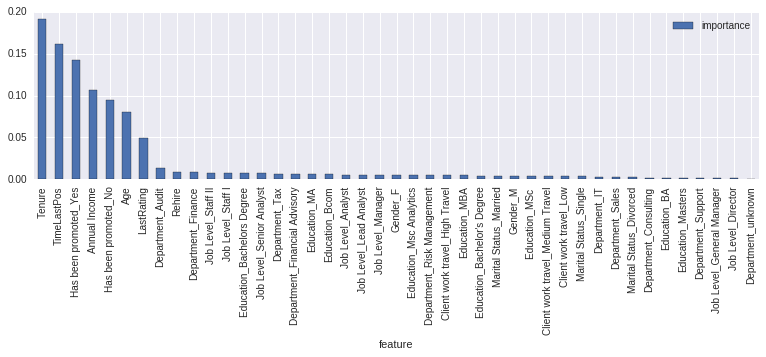

In [179]:
# load X and y
attrition_ohe = pd.get_dummies(attrition_df.drop('Terminated',axis = 1))
predictors = attrition_ohe.columns
X = attrition_ohe[predictors]
y = attrition_df['Terminated']
y = y.ravel()

# Build a forest and compute the feature importances
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

clf = RandomForestClassifier(max_features=5)
clf.fit(X_train.values, y_train)

#show to plot importances
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(clf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar(figsize = (13,3))

TimeLastPos is the third most important variable.RandomForests have difficulty in selecting important variables when they are highly correlated.Let's see the correlation plot between Tenure and TimeLastPos.

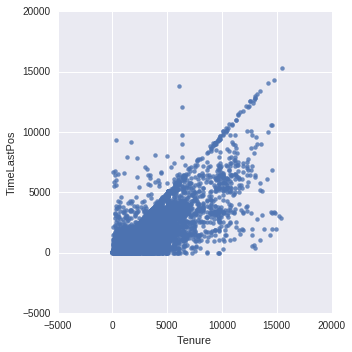

In [180]:
sns.lmplot('Tenure', 'TimeLastPos', data=attrition_df, fit_reg=False)
plt.show()

There is high correlation between the variables as is evident from this figure.Hence we will remove TimeLastPos from the data for modelling purposes.Also,more than number of days since last promotion, a variable like NumberofTimes promoted during Tenure will be more helpful.

Visualization

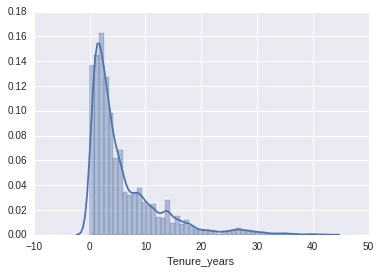

In [181]:
attrition_df['Tenure_years']= round(round((attrition_df['Tenure']/365)*12)/12,1)
attrition_df.drop('Tenure', axis=1, inplace=True)
x = attrition_df['Tenure_years']
sns.distplot(x)

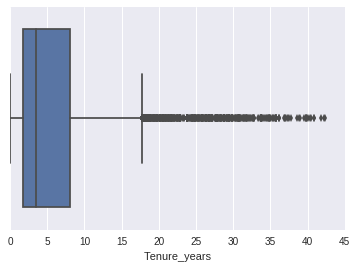

In [182]:
# It seems there are outliers ,so let's verify with a box-plot
sns.boxplot(x)

There are large number of people who have been working in the company for more than 20 years.We will create Tenure Buckets and see the characteristics of these groups.

In [183]:
bins = [0, 3, 5, 10, 15, 20, 43]
group_names = ['0-3', '3-5', '5-10', '10-15','15-20','+20']
tenure_year_bucket = pd.cut(attrition_df['Tenure_years'], bins, labels=group_names)
attrition_df['tenure_year_bucket'] = pd.cut(attrition_df['Tenure_years'], bins, labels=group_names)
attrition_df.tenure_year_bucket.fillna('0-3',inplace = True)
sum(attrition_df.tenure_year_bucket.isnull())

0

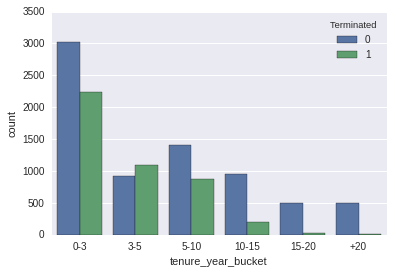

In [184]:
# See the distribution of Terminated across all age buckets
ax = sns.countplot(x="tenure_year_bucket", hue="Terminated", data=attrition_df)

This clearly shows that there are large number of people in the Tenure Bucket of 0-3 and 3-5 years who have left.
What might be the reason? Let's see the number of promotions in these buckets.

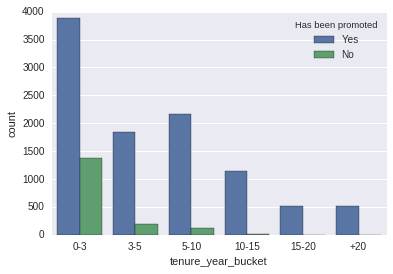

In [185]:
ax = sns.countplot(x="tenure_year_bucket", hue="Has been promoted", data=attrition_df)

There seems to be no evidence suggesting that promotions is a problem,can it be that people are leaving due to Travel issues or Departmental problems.

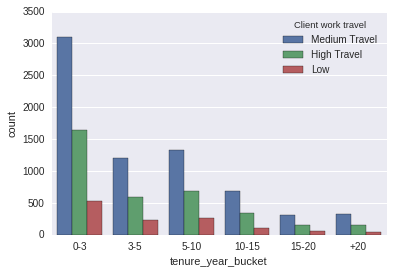

In [186]:
ax = sns.countplot(x="tenure_year_bucket", hue="Client work travel", data=attrition_df)

In the tenure bracket of 0-3 there seems to be quite a lot of travel both but this does not offer any conclusive 
evidence.Is it a problem in the departments?

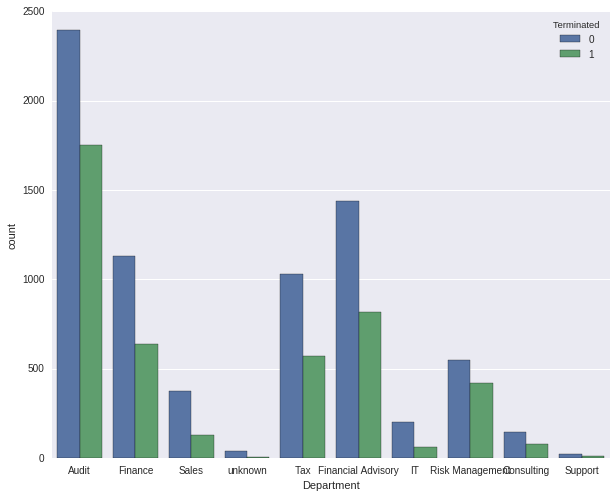

In [187]:
fig, ax = plt.subplots(figsize=(10,8))
sns.countplot(x="Department", hue="Terminated", data=attrition_df)

Audit and Financial Advisory seems to have a large number of people leaving.Let's drill down.

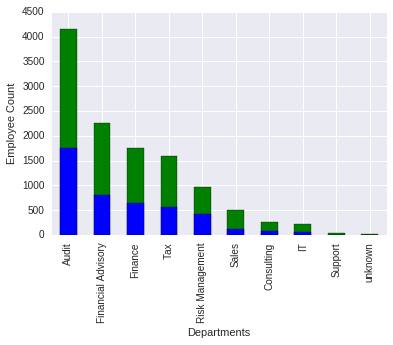

Percentage of employees that left by department 

 Risk Management       43.52
Audit                 42.25
Financial Advisory    36.18
Finance               36.09
Tax                   35.65
Consulting            35.45
Support               29.63
Sales                 24.95
IT                    23.95
unknown                7.32
Name: Department, dtype: float64


In [188]:
left_data = attrition_df[attrition_df.Terminated == 1]
attrition_df.Department.value_counts().plot(kind='bar',color = 'green')
left_data.Department.value_counts().plot(kind='bar', color = 'blue')
plt.title =('Share of Employees that Left by Department')
plt.xlabel('Departments')
plt.ylabel('Employee Count')
plt.show()
percent_left = round(left_data.Department.value_counts()/ attrition_df.Department.value_counts() * 100, 2)
print('Percentage of employees that left by department \n\n', percent_left.sort_values(ascending = False))

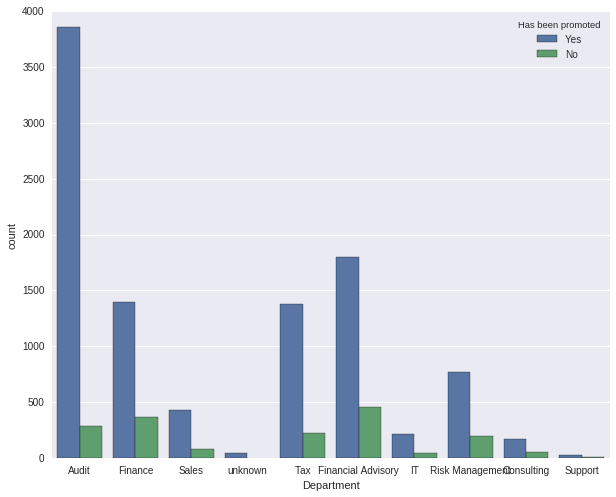

In [189]:
# Let's see the promotions by Dept.
fig, ax = plt.subplots(figsize=(10,8))
sns.countplot(x="Department", hue="Has been promoted", data=attrition_df)

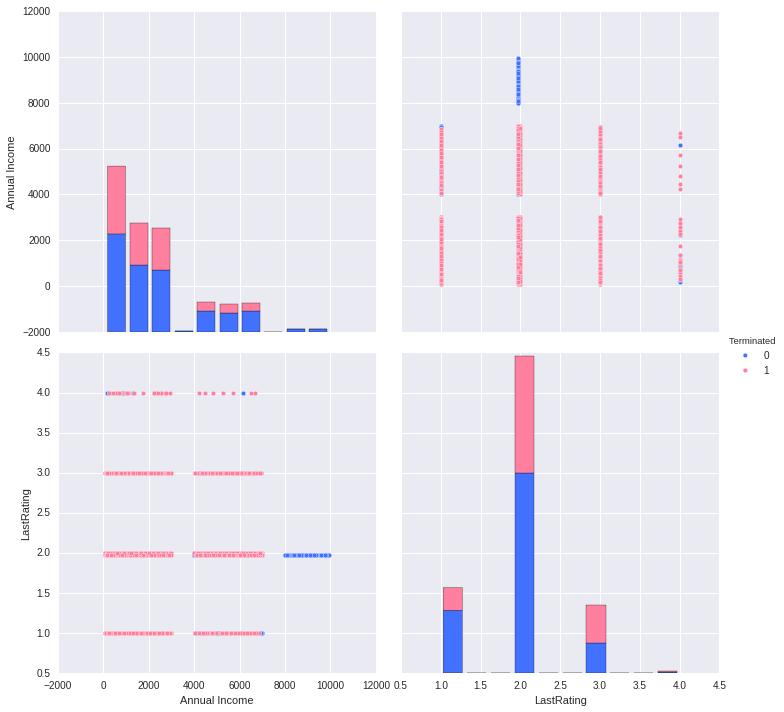

In [190]:
#let's pairplot
plt.figure(figsize=[12,12])
#sns.set(style="ticks")
sns.pairplot(attrition_df, hue='Terminated',size = 5,aspect = 1,palette={0:(0.2588,0.4433,1.0),1:(1.0,0.5,0.62)},
             vars=['Annual Income','LastRating'])
plt.show()

It seems that the Annual Income is a cause for many people leaving.Let us divide the Income into buckets - 'Low',
'Medium' and 'High' and try to re-confirm.

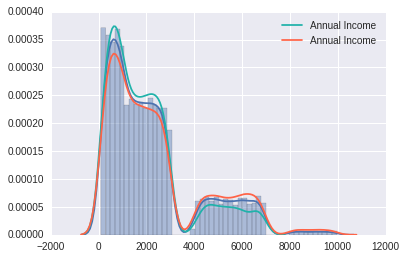

In [191]:
sns.distplot(np.array(attrition_df['Annual Income'].values));
attrition_df['Annual Income'].describe();
sns.kdeplot(attrition_df.loc[attrition_df["Terminated"] == 1, "Annual Income"], color = "lightseagreen")
sns.kdeplot(attrition_df.loc[attrition_df["Terminated"] == 0, "Annual Income"], color = "tomato")

In [192]:
#Divide Annual Income similarly
bins = [0, 1715, 3000,10000]
group_names = ['Low', 'Medium', 'High']
salary_bucket = pd.cut(attrition_df['Annual Income'], bins, labels=group_names)
attrition_df['salary_bucket'] = pd.cut(attrition_df['Annual Income'], bins, labels=group_names)
attrition_df.salary_bucket.value_counts()

Low       5892
Medium    3571
High      2317
Name: salary_bucket, dtype: int64

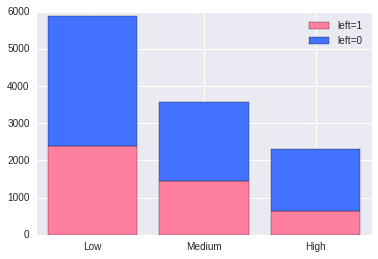

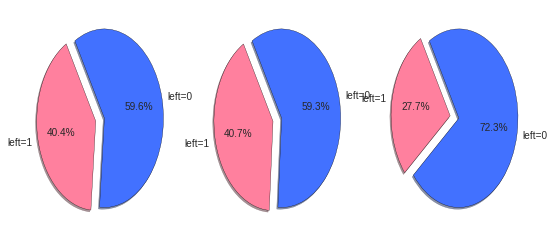

In [193]:
fig = plt.figure()
ax = fig.add_subplot(111)
salary_tick = ['Low','Medium','High']
#number of the the people in each group for both the ones who left and the ones who did not
salary_left = attrition_df[attrition_df['Terminated'] == 1].salary_bucket.value_counts()[0:3]
salary_not_left = attrition_df[attrition_df['Terminated'] == 0].salary_bucket.value_counts()[0:3]

ax.bar(np.arange(len(salary_tick)),salary_left,align='center',color=(1.0,0.5,0.62))
ax.bar(np.arange(len(salary_tick)),salary_not_left,align='center',color=(0.2588,0.4433,1.0),bottom=salary_left)

plt.legend(['left=1','left=0'])
plt.xticks(np.arange(len(salary_tick)), salary_tick)
plt.show()

plt.figure(figsize=[9,4])

for i in range(0,3):
    plt.subplot(1,3,i+1)
    plt.pie([salary_left[i],salary_not_left[i]],
           labels=['left=1','left=0'],
           shadow=True,startangle=120,colors=[(1.0,0.5,0.62),(0.2588,0.4433,1.0)],
           autopct='%1.1f%%',explode=[0.15,0])
    #plt.title(salary_tick[i])

plt.show()

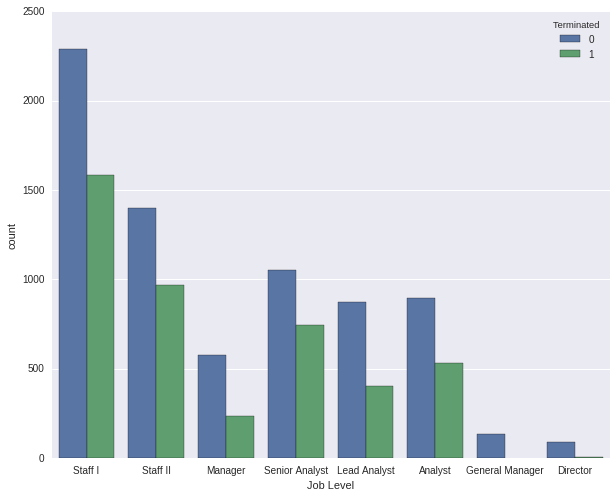

In [194]:
fig, ax = plt.subplots(figsize=(10,8))
sns.countplot(x="Job Level", hue="Terminated", data=attrition_df)

We have seen earlier that salary is a factor which is influencing people staying or leaving.Lets see its breakup 
department wise.

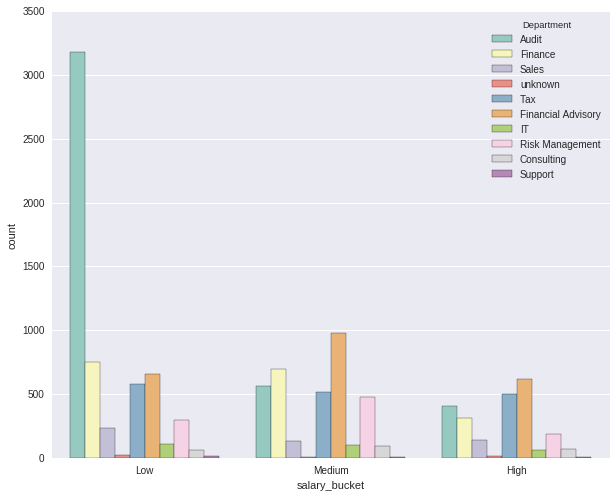

In [195]:
fig, ax = plt.subplots(figsize=(10,8))
sns.countplot(x='salary_bucket', hue='Department', data=attrition_df, palette='Set3')

It seems that low salary and department are influencing Leaving or Staying Decisions.

In [196]:
#Chi-Sq test for Terminated = 0/1 across Department and Salary Bucket.
attrition_df_left = attrition_df[attrition_df['Terminated'] == 1]
contingency = pd.crosstab(attrition_df_left.Department,attrition_df_left.salary_bucket,margins = True)
print (contingency)

salary_bucket        Low  Medium  High   All
Department                                  
Audit               1444     227    82  1753
Consulting            16      44    18    78
Finance              264     282    91   637
Financial Advisory   237     374   203   814
IT                    17      26    20    63
Risk Management      130     232    58   420
Sales                 44      44    37   125
Support                4       3     1     8
Tax                  220     219   131   570
unknown                2       1     0     3
All                 2378    1452   641  4471


In [197]:
from scipy.stats import chi2_contingency
c, p, dof, expected = chi2_contingency(contingency)
print (c,p)

1092.63580175 1.35591027672e-210


This results shows us that there is significant difference in the number of people leaving based on Departments and Salary.
Furthermore, I am interested in performing analysis on this data in the following groups:
Good performers who left the company
Good performers who stayed with the company
Average/Below Average performers who left the company
Average/Below A performers who stayed with the company
I think it will be interesting to see the similarities and differences between these groups.
What is an Above Average performer?
I will define an above average performer as anyone who's performance evaluation was at least 1 standard deviation above the mean. Everyone else is average or below average.

In [198]:
eval_mean = attrition_df['LastRating'].mean()
eval_std = np.std(attrition_df['LastRating'])
attrition_df['performance(standard units)'] = (attrition_df['LastRating']- eval_mean)/eval_std

def performance_label(row):
    performance = row['performance(standard units)']
    if performance > 1.96:
        result = 'Above Average'
    else:
        result = 'Average or Below'
    return(result)

attrition_df['performance label'] = attrition_df.apply(performance_label, axis = 1)

left_dict = {1: 'left', 0: 'stayed'}

attrition_df['left(as_string)'] = (attrition_df['Terminated'].map(left_dict))
attrition_df.head()

,Terminated,Rehire,Department,Job Level,TimeLastPos,Has been promoted,LastRating,Client work travel,Education,Gender,Marital Status,Annual Income,Age,Tenure_years,tenure_year_bucket,salary_bucket,performance(standard units),performance label,left(as_string)
0,0,False,Audit,Staff I,15294,Yes,2.000000,Medium Travel,Bachelors Degree,M,Single,135,55,42.4,+20,Low,5.893929e-02,Average or Below,stayed
1,0,False,Audit,Staff II,14328,Yes,3.000000,Medium Travel,MBA,M,Married,1198,40,40.3,+20,Low,1.770850e+00,Average or Below,stayed
2,0,False,Finance,Staff I,14040,Yes,1.965571,High Travel,Bachelor's Degree,F,Divorced,825,31,38.9,+20,Low,-3.216515e-10,Average or Below,stayed
3,0,True,Audit,Staff I,13825,Yes,2.000000,High Travel,MSc,F,Divorced,298,53,16.8,15-20,Low,5.893929e-02,Average or Below,stayed
4,0,False,Sales,Staff I,13408,Yes,2.000000,Low,Bachelors Degree,F,Single,111,29,36.8,+20,Low,5.893929e-02,Average or Below,stayed


In [199]:
#Next we'll take a look at the average values for numerical columns in our data as an initial look into the potential problem.
columns = (attrition_df.columns)
num_columns = (attrition_df._get_numeric_data().columns)

sep_hr_data = attrition_df
sep_hr_data['Performance cluster'] = sep_hr_data['left(as_string)'] + ' : ' + sep_hr_data['performance label']

sep_hr_pivot = sep_hr_data.pivot_table(index= (['Performance cluster']), values =num_columns, aggfunc=np.mean)
sep_hr_pivot.transpose()

Performance cluster,left : Above Average,left : Average or Below,stayed : Above Average,stayed : Average or Below
Age,39.341463,40.160722,37.250000,39.921338
Annual Income,2080.121951,1989.073815,1311.500000,2410.692476
LastRating,4.000000,2.079870,4.000000,1.881403
Rehire,0.121951,0.076072,0.166667,0.072359
Tenure_years,4.295122,3.825485,9.141667,7.198780
TimeLastPos,1039.536585,790.369300,1981.833333,1389.556530
performance(standard units),3.482760,0.195670,3.482760,-0.144087


In [200]:
#Now select the attributes from the dataframe to be used in modelling attrition:
attrition_df.columns

Index(['Terminated', 'Rehire', 'Department', 'Job Level', 'TimeLastPos',
       'Has been promoted', 'LastRating', 'Client work travel', 'Education',
       'Gender', 'Marital Status', 'Annual Income', 'Age', 'Tenure_years',
       'tenure_year_bucket', 'salary_bucket', 'performance(standard units)',
       'performance label', 'left(as_string)', 'Performance cluster'],
      dtype='object')

In [201]:
#Set aside test set:
cols_to_keep = ['Rehire', 'Department', 'Job Level', 'Has been promoted',
                'LastRating', 'Client work travel', 'Education','Gender', 'Marital Status',
                   'tenure_year_bucket', 'salary_bucket','Terminated']
attrition_df = attrition_df[cols_to_keep]
attrition_df.head()
attrition_df.dtypes
#Re-order columns
cols = attrition_df.columns.tolist()
cols.insert(0, cols.pop(cols.index('Terminated')))
attrition_df = attrition_df.reindex(columns= cols)

# Stratified sampling used for imbalanced classes (80:20 split)
spliter = StratifiedShuffleSplit( n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in spliter.split(attrition_df, attrition_df['Terminated']):
    train_set = attrition_df.loc[train_index]
    test_set = attrition_df.loc[test_index]
# Apply one-hot-encoding to both training and testing sets
cols_categorical = ['Rehire', 'Department', 'Job Level', 'Has been promoted','Client work travel',
                    'Education','Gender', 'Marital Status','tenure_year_bucket', 'salary_bucket']

train_set = pd.get_dummies(train_set, columns=cols_categorical)
test_set = pd.get_dummies(test_set, columns=cols_categorical)
train_set.head()
# Separate features matrix and target array
X_train, y_train = (train_set.iloc[:, 1:].values, train_set.iloc[:,0].values)
X_test, y_test = (test_set.iloc[:, 1:].values, test_set.iloc[:,0].values)

In [202]:
# Machine learning framework:
from sklearn.pipeline import Pipeline
# Preprocessing
from sklearn.preprocessing import StandardScaler
# Estimators
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# Evaluation tools
from sklearn.metrics import (
    roc_auc_score, classification_report
)
from sklearn.model_selection import (
    StratifiedShuffleSplit, cross_val_score,
    GridSearchCV, RandomizedSearchCV,
)

def make_pipe(estimator):
    '''Model pipeline'''
    return Pipeline([
        ('scaler', StandardScaler()), ('estimator', estimator)
    ])


def gridsearch(pipe, param_grid, **cv_params):
    '''Grid or randomized search for selecting hyperparameters'''
    n_hyperparams = sum(len(v) for v in param_grid.values())
    if(n_hyperparams < 15):
        gs = GridSearchCV(pipe, param_grid, **cv_params)
    else:
        gs = RandomizedSearchCV(
            pipe, param_grid, **cv_params, n_iter=15
        )
    return gs


class Classifier():
    global metric
    metric = dict(scoring='roc_auc')

    def __init__(self):
        pass

    def assess(self, estimator, X, y, param_grid):
        '''Performance assessments for selecting algorithms
        Using 5x2 nested cross-validation'''
        pipe = make_pipe(estimator)
        # Inner loop: 2-fold CV for hyperparameter selection
        gs = gridsearch(pipe, param_grid, cv=2, **metric)
        # Outer loop: 5-fold CV for model training
        scores = cross_val_score(gs, X, y, cv=5, **metric)
        return (scores.mean(), scores.std())

    def fit(self, estimator, X, y, param_grid):
        '''Train selected model'''
        pipe = make_pipe(estimator)
        gs = gridsearch(pipe, param_grid, cv=5, **metric)
        _ = gs.fit(X, y)
        self.best_pipe_ = gs.best_estimator_
        best_estimator = (
            gs.best_estimator_.named_steps['estimator']
        )
        self.feature_importances_ = (
            best_estimator.feature_importances_
        )
        self.best_params_ = gs.best_params_
        self.score_ = gs.best_score_
        return None

    def predict(self, X):
        '''Make predictions for new data'''
        return self.best_pipe_.predict(X)

In [203]:
#Model evaluation

# Hyperparameters common for all models under evaluations
param_common = dict(random_state=42, class_weight='balanced')

# Dataframe for score keeping
model_list = ['Logistic regression', 'Decision tree', 'Random forest']
metric_list = ['auc_mean', 'auc_std', 'runtime (s)']
df_score_eval = pd.DataFrame(columns=model_list, index=metric_list)
#df_score_eval.head()

In [126]:
model_id = model_list[0]
import time
# Modeling : Logistic Regression.
lr = LogisticRegression(**param_common, n_jobs=-1)
param_grid = {
    'estimator__penalty': ['l1', 'l2'],
    'estimator__C': np.logspace(-5, 5, 11),
    'estimator__fit_intercept': [True, False]
}
model = Classifier()
t_start = time.time()
auc_mean, auc_std = model.assess(lr, X_train, y_train, param_grid)
t_elapsed = time.time() - t_start

# Keep score
df_score_eval[model_id] = (auc_mean, auc_std, t_elapsed)
df_score_eval.head()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [204]:
model_id = model_list[1]

# Modeling
tree = DecisionTreeClassifier(**param_common)
param_grid = {
    'estimator__max_depth': [None] + list(range(1, 11)),
    'estimator__min_samples_leaf': np.arange(1, 10)
}
model = Classifier()
t_start = time.time()
auc_mean, auc_std = model.assess(tree, X_train, y_train, param_grid)
t_elapsed = time.time() - t_start

# Keep score
df_score_eval[model_id] = (auc_mean, auc_std, t_elapsed)
df_score_eval.head()

TypeError: take_nd() got an unexpected keyword argument 'axis'

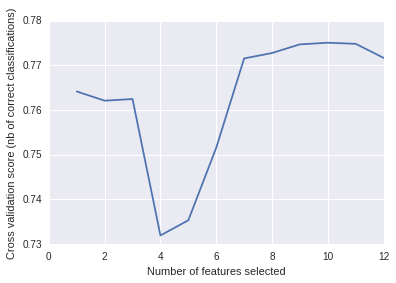

In [84]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()